# Self-Driving Car Engineer Nanodegree

### Deep Learning Project: Build a Traffic Sign Recognition Classifier


**Test data source & references**

[German Traffic Sign Repo](benchmark.ini.rub.de/?section=gtsrb&subsection=dataset#Imageformat)


### Project Rubric

The project rubric and submission guidelines is available [here](./TrafficSignProjectRubric.pdf). All items have been addressed withoin the notebooks submitted. 

---
# 1. Data Process & Visualization

>**Note**: <span style="color:red">Please run the notebook [here](./Traffic_Sign_Classifier--Data_Pre-process.ipynb) before proceeding with the classifier network below.</span> 


---
# 2. LeNet Classifier

This program reads pre-processed data from pickled data-source and applies the LeNet model for traffic sign classification.
The TensorFlow model is then pickled in the `./models` sub-directory for the final evaluation phase.  

>**Strategy**: 
> 1. Training hyper-parameters were selected afetr a fair amount  of parameter sweeps but essentially are empirircal in the choice. The set values in this notebook perform with goo accuracy for the particular data-sets chosen for validation & testing. 
> 2. A drop-out scheme was chosen as a simpler mechanism to reduce weight variance rahter than L2-regularization or other more elaborate methods. 
> 3. An early training termination crietria was chosen to be when per-epoch training accuracy (measured on validation set) was found to decrease by $\le \epsilon=10^{-3}$. This was done primarily to shorten training wall-clock times for a model with *sufficient* accuracy for the particular classifier task.  
> 4. Note that the early termination kicks in only after _a minimum number of epochs_ (chosen here to be $E = 15$) have been run. 

In [1]:
### Import packages required for notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import datetime
import time
import pickle
import csv
import random
import os
import math
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
import tensorflow as tf
import cv2

print("Packages imported ...")

Packages imported ...


---
## 2.1 Load Pickled Data

In [2]:
def print_stats(X, arrayname = ''):
    print(arrayname, ": {StdDev, Mean, Range, Min, Max} =\n\t",X.std(axis=(0,1,2)), X.mean(axis=(0,1,2)), X.ptp(), X.min(axis=(0,1,2)), X.max(axis=(0,1,2)))    
    return

# Load pickled normalized-data
pickle_file = './dataset/Trafficsigns_NormalizedDataSet.p'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    y_trn = pickle_data['train_labels']
    X_train_size = pickle_data['train_size']
    X_train_loc = pickle_data['train_roi']
    X_trn = pickle_data['trn_norm']
    X_train_gray_norm = pickle_data['train_gray_norm']
    
    y_val = pickle_data['valid_labels']
    X_valid_size = pickle_data['valid_size']
    X_valid_loc = pickle_data['valid_roi']
    X_val = pickle_data['val_norm']
    X_valid_gray_norm = pickle_data['valid_gray_norm']
    
    y_tst = pickle_data['test_labels']
    X_test_size = pickle_data['test_size']
    X_test_loc = pickle_data['test_roi']
    X_tst = pickle_data['tst_norm']
    X_test_gray_norm = pickle_data['test_gray_norm']

    signname_hash = pickle_data['signname_hash']

    del pickle_data  # Free up memory

#
# Dataset summary
#
total_samples = len(X_trn)+len(X_val)+len(X_tst)
n_classes = len(set(y_trn))
n_test = len(X_tst)
n_train = len(X_trn)
n_validation = len(X_val)

print("Unique labels = ",len(set(y_trn)))
print("Training set: ")
print("\t Number of samples = ",len(X_trn), ":({0:.2f}%)".format(len(X_trn)/total_samples*100))
print("\t Image dimension   = ",X_trn.shape[1],"x", X_trn.shape[2],"x", X_trn.shape[3])
print("\t Data types (X, y) = ",X_trn.dtype,",", y_trn.dtype)
print("\t Data range (X, y) = ",np.ptp(X_trn),",", np.ptp(y_trn))
print("Validation set: ")
print("\t Number of samples = ",len(X_val), ":({0:.2f}%)".format(len(X_val)/total_samples*100))
print("\t Image dimension   = ",X_val.shape[1],"x", X_val.shape[2],"x", X_val.shape[3])
print("\t Data types (X, y) = ",X_val.dtype,",", y_val.dtype)
print("\t Data range (X, y) = ",np.ptp(X_val),",", np.ptp(y_val))
print("Test set: ")
print("\t Number of samples = ",len(X_tst), ":({0:.2f}%)".format(len(X_tst)/total_samples*100))
print("\t Image dimension   = ",X_tst.shape[1],"x", X_tst.shape[2],"x", X_tst.shape[3])
print("\t Data types (X, y) = ",X_tst.dtype,",", y_tst.dtype)
print("\t Data range (X, y) = ",np.ptp(X_tst),",", np.ptp(y_tst))

print('Data loaded ...')

print('\nData Summary Statistics:')
print_stats(X_trn, "train")
print_stats(X_val, "valid")
print_stats(X_tst, "test")


Unique labels =  43
Training set: 
	 Number of samples =  34799 :(67.13%)
	 Image dimension   =  32 x 32 x 3
	 Data types (X, y) =  float32 , int32
	 Data range (X, y) =  1.99219 , 42
Validation set: 
	 Number of samples =  4410 :(8.51%)
	 Image dimension   =  32 x 32 x 3
	 Data types (X, y) =  float32 , int32
	 Data range (X, y) =  1.99219 , 42
Test set: 
	 Number of samples =  12630 :(24.36%)
	 Image dimension   =  32 x 32 x 3
	 Data types (X, y) =  float32 , int32
	 Data range (X, y) =  1.99219 , 42
Data loaded ...

Data Summary Statistics:
train : {StdDev, Mean, Range, Min, Max} =
	 [ 0.51165527  0.48472473  0.49452567] [-0.34411597 -0.41338861 -0.39395115] 1.99219 [-1.        -0.9765625 -1.       ] [ 0.9921875  0.9921875  0.9921875]
valid : {StdDev, Mean, Range, Min, Max} =
	 [ 0.55156767  0.53303057  0.54848373] [-0.31732112 -0.3713493  -0.35102305] 1.99219 [-1.      -0.96875 -1.     ] [ 0.9921875  0.9921875  0.9921875]
test : {StdDev, Mean, Range, Min, Max} =
	 [ 0.53742504  0.5

----

## 2.1 LeNet Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

>**Note**: No padding is required for this implementation as the normalized data-set has be re-sized to 32 x 32.

>**Note**: RGB images are used here, set `USE_GRAYSCALE = True` to use gray-scaled versions. 

## 2.2 TensorFlow Environment Hyper-Parameters

Re-shuffle data-set to remove hidden biases in labelled sequences



**Hyperparameter Record** 

> *LeNet*: `USE_GRAYSCALE = False`, `EPOCHS = 50`, `BATCH_SIZE = 128`, `KEEP_PROB = .85`, `LEARN_RATE = 1e-3`, `USE_SGD = 'Adam'` 


In [3]:
# Hyper parameters

USE_ARCH = 'LeNet' # choose ML network {LeNet, GoogLeNet,AlexNet}
USE_GRAYSCALE = False
if (USE_GRAYSCALE):
    in_ch = 1
else:
    in_ch = 3
    
if (USE_ARCH == 'LeNet'):
    EPOCHS = 50
    BATCH_SIZE = 128
    KEEP_PROB = .85 # 0.5 # Dropout, probability to keep units
    LEARN_RATE = 1e-3 # learning rate
    USE_SGD = 'Adam' # {Adam, SGD}
    EARLYTERM_EPS = 1e-3 # early termination threshold
    MIN_EPOCHS = 10 # number fo epoch runs after early-termination check kicks in    
elif (USE_ARCH == 'AlexNet'): 
    EPOCHS = 50
    BATCH_SIZE = 128
    KEEP_PROB = 0.5 # Dropout, probability to keep units
    LEARN_RATE = 1e-3 # learning rate
    USE_SGD = 'Adam' # {Adam, SGD}
    BETA = 1e-4 # weight regularization factor
    
if (USE_GRAYSCALE):    
    X_trn, y_trn = shuffle(X_train_gray_norm, y_trn)
    X_val, y_val = shuffle(X_valid_gray_norm, y_val)
    X_tst, y_tst = shuffle(X_test_gray_norm, y_tst)
else:
    X_trn, y_trn = shuffle(X_trn, y_trn)
    X_val, y_val = shuffle(X_val, y_val)
    X_tst, y_tst = shuffle(X_tst, y_tst)


---
## 2.3 LeNet5 Network

![LeNEt5 Architecture](./lenet_archdiagram.png)

In [4]:
def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='VALID')

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)    
    return tf.nn.relu(x)
    #return tf.nn.sigmoid(x)

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    # Network Parameters
    dropout = KEEP_PROB
    
    # Store layers weight & bias
    weights = {
        'wc1': tf.Variable(tf.truncated_normal((5, 5, in_ch, 6), mu, sigma)),
        'wc2': tf.Variable(tf.truncated_normal((5, 5, 6, 16), mu, sigma)),
        'wd1': tf.Variable(tf.truncated_normal((5*5*16, 120), mu, sigma)),
        'wd2': tf.Variable(tf.truncated_normal((120, 84), mu, sigma)),
        'out': tf.Variable(tf.truncated_normal((84, n_classes), mu, sigma))}

    biases = {
        'bc1': tf.Variable(tf.zeros(6)),
        'bc2': tf.Variable(tf.zeros(16)),
        'bd1': tf.Variable(tf.zeros(120)),
        'bd2': tf.Variable(tf.zeros(84)),
        'out': tf.Variable(tf.zeros(n_classes))}
    
    # TODO: Layer 1: Convolutional. Input = 32x32x<in_ch>. Output = 28x28x6.
    # TODO: Activation.
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    #  --- Layer 1 - 32*32*<in_ch> to 14*14*6
    conv1 = conv2d(x, weights['wc1'], biases['bc1']) # output: 28x28x6
    conv1 = maxpool2d(conv1, k=2) # output 14x14x6

    # TODO: Layer 2: Convolutional. Input = 14x14x6. Output = 10x10x16.    
    # TODO: Activation.
    # TODO: Pooling. Input = 14x14x6. Output = 5x5x16.
    #  --- Layer 2 - 14*14*6 to 5*5*16
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2']) # output: 10x10x16
    conv2 = maxpool2d(conv2, k=2) # output 5x5x16

    # TODO: Flatten. Input = 5x5x16. Output = 400.    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    # TODO: Activation.
    # --- Layer 3 - 5*5*x16 to 120
    #fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.contrib.layers.flatten(conv2)
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
        
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.    
    # TODO: Activation.
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)
    
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 10.
    #  --- Output Layer - class prediction - 84 to 10
    logits = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    
    #print(tf.summary.image("weights_wc1", weights['wc1']))
        
    # return flattened weights+biases for regularization 
    #flatweights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    #flatweights = weights['wc1']

    return logits

### 2.3.1 Features and Labels

Train LeNet to classify traffic-sign data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

In [5]:
x = tf.placeholder(tf.float32, (None, 32, 32, in_ch))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

### 2.3.2 Training Pipeline

Create a training pipeline that uses the model to classify traffic-sign data.

Using dropout (instead of L2 regularization) for weights-culling to avoid over-fitting (high-variance) of the model.   

In [6]:
# choose network architecture to run
logits = LeNet(x)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
if (USE_SGD == 'Adam'):
    optimizer = tf.train.AdamOptimizer(learning_rate = LEARN_RATE)
elif (USE_SGD == 'SGD'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = LEARN_RATE)
training_operation = optimizer.minimize(loss_operation)

### 2.3.3 Model Evaluation

Evaluate how well the loss and accuracy of the model for a given dataset.

In [7]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy, loss = sess.run([accuracy_operation, loss_operation], feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples, loss

### 2.3.4 Train & Validate the Model

Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

Save the model after training.


Training...34799 samples
Epochs 100% done : Accuracy 0.935
Model saved
- - - - - - -
Elapsed time: 37.5 [min]
CPU process time: 112.3 [min]


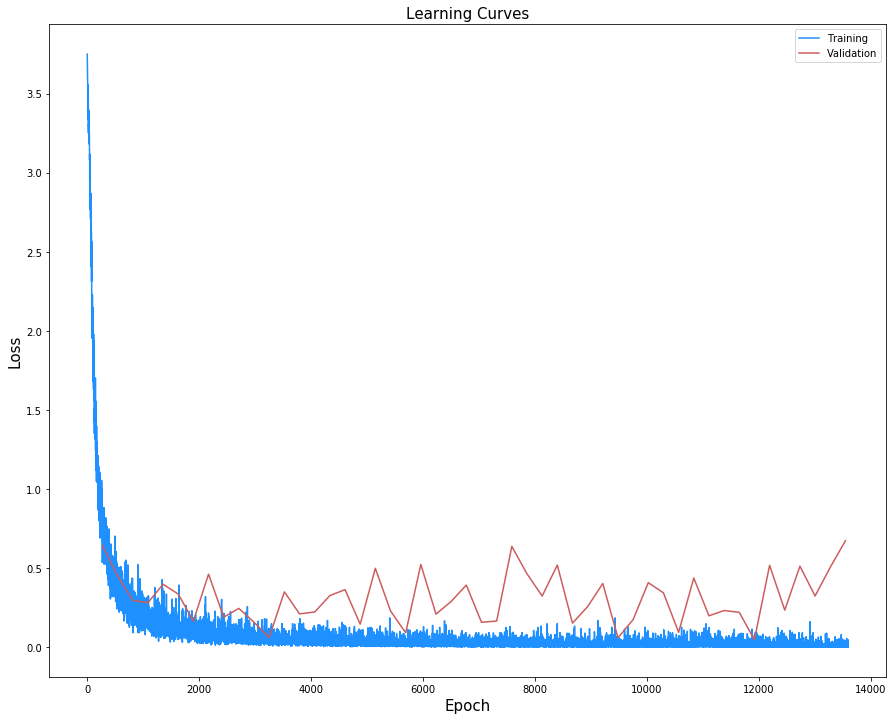

In [8]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

t1_start = time.perf_counter()
t2_start = time.process_time()

train_loss = []
valid_loss = []
valid_acc = []
saver = tf.train.Saver()


DONOT_TRAIN = False

if (DONOT_TRAIN == False):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_trn)

        print("Training...{} samples".format(num_examples))       
        for i in range(EPOCHS):
            X_trn, y_trn = shuffle(X_trn, y_trn)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_trn[offset:end], y_trn[offset:end]
                #batch_x = batch_x.reshape(len(batch_x), 32, 32, in_ch)
                _, tloss = sess.run([training_operation, loss_operation], feed_dict={x: batch_x, y: batch_y})
                train_loss.append(tloss)

            validation_accuracy, vloss = evaluate(X_val, y_val)
            valid_loss.append(vloss)
            valid_acc.append(validation_accuracy)
            
            print("Epochs {:2.0%} done : Accuracy {:.3f}".format((i+1)/EPOCHS, validation_accuracy), end="\r")
            #
            # check for early termination from epochs based on evolution of "recent" history of validation accuracy
            #
            """
            if (len(valid_acc) > MIN_EPOCHS): # only after minimum epochs have been run
                if ((valid_acc[-1]>valid_acc[-2]) and 
                    (valid_acc[-2]>valid_acc[-3])): # check for monotonic increase                   
                    if ((valid_acc[-1]-valid_acc[-2]) < EARLYTERM_EPS):
                    break            
            """
        print()

        #try:
        #    saver
        #except NameError:
        #    saver = tf.train.Saver()
        saver.save(sess, './models/lenet_trafficsign.ckpt')
        print("Model saved")

t1_stop = time.perf_counter()
t2_stop = time.process_time()
print("- - - - - - -")
print("Elapsed time: %.1f [min]" % ((t1_stop-t1_start)/60))
print("CPU process time: %.1f [min]" % ((t2_stop-t2_start)/60))
 
#
# Plot Learning Curves
#
fig4 = plt.figure(figsize=(15,5))
plt.plot(train_loss, label='Training', color='dodgerblue')
plt.plot([(i+1) * int(num_examples / BATCH_SIZE) for i in range(EPOCHS)], valid_loss, label='Validation', color='indianred')
plt.title('Learning Curves', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.gcf().set_size_inches(15, 12)
plt.legend()
#plt.tight_layout()
plt.savefig('TrafficSigns_LeNet_LearningCurve.png', dpi=100)
plt.show()    

---

## 2.4 Model Performance on Test Images

Apply the validted model on the test set and predict traffic-sizn class ID. Analyze performance to meet minimum accuracy of `> 95%`. 

There are two test modes, using pickled test data & using traffic sign images from the German traffic sign data-base. 
Obtain the top-5 detected class IDs along with the detection prbabilities (`softmax` values).

---

### 2.4.1 Internal Test Set

Test Accuracy = 0.927


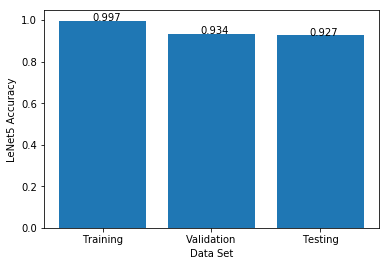

In [9]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
with tf.Session() as sess:
    saver.restore(sess, './models/lenet_trafficsign.ckpt')
    train_accuracy, _ = evaluate(X_trn, y_trn)
    valid_accuracy, _ = evaluate(X_val, y_val)
    test_accuracy, _ = evaluate(X_tst, y_tst)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    
    # test data detected probabilities
    test_logits = sess.run(logits, feed_dict={x: X_tst})
    test_probs = sess.run(tf.nn.softmax(test_logits))
    top5_probs, top5_indices = sess.run(tf.nn.top_k(test_probs, k=5))

#
# Plot LeNet5 accuracy comaprisons across train/validation/test data-set
#
tick_labels = ["Training", "Validation", "Testing"]
fig6 = plt.figure()
plt.bar(range(3), [train_accuracy, valid_accuracy, test_accuracy])
plt.xlabel('Data Set')
plt.ylabel('LeNet5 Accuracy')
plt.xticks(range(3), tick_labels)
for x_,y_ in zip(range(3), [train_accuracy, valid_accuracy, test_accuracy]):
    plt.text(x_ - 0.1, y_, '%.3f'%y_)
plt.savefig('TrafficSigns_LeNet_AccuracyCompare.png', dpi=100)
plt.show()

### 2.4.2 Output Test Top-5 Probabilities

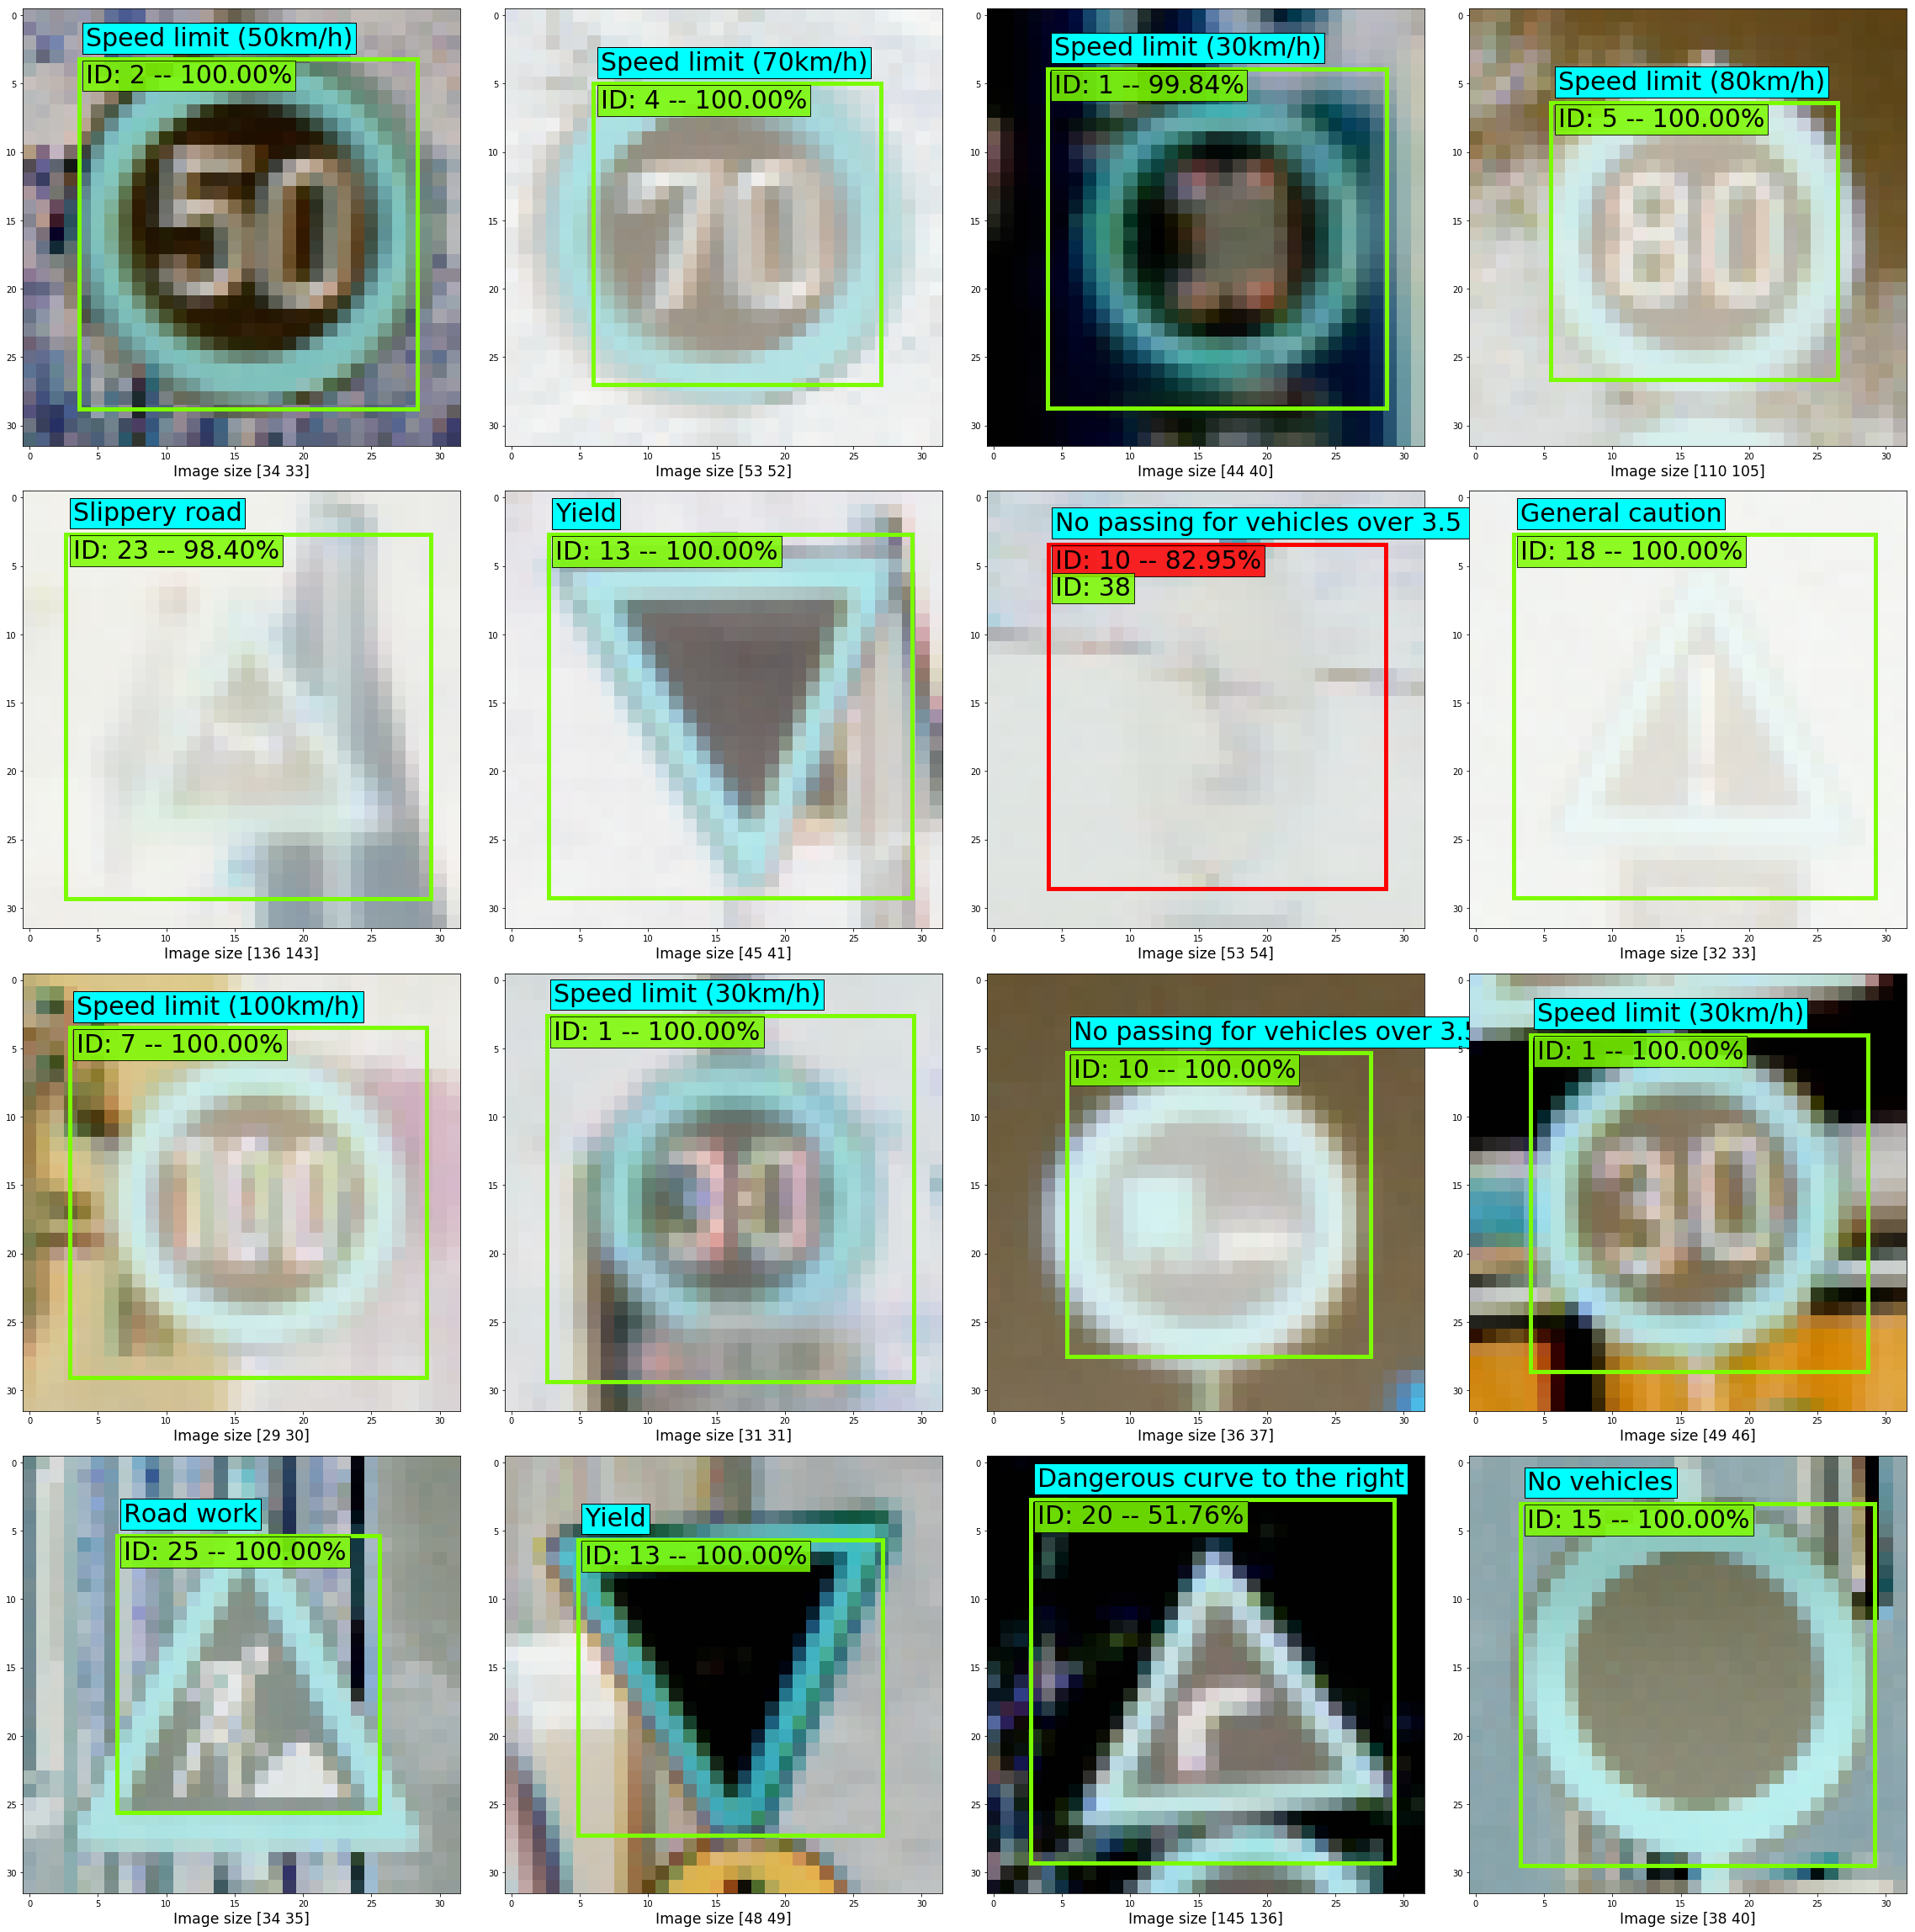

In [10]:
## Top-5 Analysis for test images
#print(tf.metrics.average_precision_at_k(y_tst,test_probs))



### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
#
# show traffic sign training images in 8x8 grid
#

# un-normalize test images for display
X_ = (X_tst+1.) * 128.

N = 4
select_images = np.random.randint(1,n_test,N*N) # use the ones selected/displayed above
fig5 = plt.figure()
plt.subplots(figsize=(32,32))
#plt.suptitle("Illustrative Training Samples with Traffic-Sign Boundary Annotation", size='xx-large')
for row in range(N):
    for col in range(N):
        idx = N*row+col
        
        # plot traffic sign with detection probability
        ax = plt.subplot(N,N,idx+1)        
        plt.imshow(X_[select_images[idx]])
        plt.xlabel('Image size {}'.format(X_train_size[select_images[idx]]), size='xx-large')
        # traffic sign coordinates scaled to 32x32
        x1, y1, x2, y2 = X_test_loc[select_images[idx]]
        x1 *= 32/X_test_size[select_images[idx]][0] 
        x2 *= 32/X_test_size[select_images[idx]][0] 
        y1 *= 32/X_test_size[select_images[idx]][1] 
        y2 *= 32/X_test_size[select_images[idx]][1] 
        lbl = top5_indices[select_images[idx]][0]
        prob = top5_probs[select_images[idx]][0]
               
        if (lbl == y_tst[select_images[idx]]): # correct detect GREEN
            ax.add_patch(patches.Rectangle((x1,y1), x2-x1, y2-y1, color='lawngreen', linewidth=5, fill=False))
            plt.text(x1+.5,y1+1.75,"ID: {} -- {:.2f}%".format(lbl, prob*100), fontsize=30, bbox=dict(facecolor='lawngreen', alpha=0.85))
        else : # incorrect detect RED
            #print(y_tst[select_images[idx]], " : ", top5_indices[select_images[idx]])
            ax.add_patch(patches.Rectangle((x1,y1), x2-x1, y2-y1, color='red', linewidth=5, fill=False))
            plt.text(x1+.5,y1+1.75,"ID: {} -- {:.2f}%".format(lbl, prob*100), fontsize=30, bbox=dict(facecolor='red', alpha=0.85))
            plt.text(x1+.5,y1+3.75,"ID: {}".format(y_tst[select_images[idx]]), fontsize=30, bbox=dict(facecolor='lawngreen', alpha=0.85))
        plt.text(x1+.5,y1-1,"{}".format(signname_hash[str(lbl)]), fontsize=30, bbox=dict(facecolor='cyan', alpha=1.))

        """
        # plot top-5 probabilities (softmax values)
        ax = plt.subplot(2*N,N,idx+2)        
        rects = ax.barh(np.arange(5), top5_probs[select_images[idx]], align='center', height=.5, color='skyblue', ec='dodgerblue')
        for rect in rects:
            width = int(rect.get_width())
            rankStr = str(width)+"%"
            if (width < 15):
                xloc = width + 1
                clr = 'black'
                align = 'left'
            else:
                xloc = 0.98*width
                clr = 'white'
                align = 'right'
        yloc = rect.get_y() + rect.get_height()/2.0
        label = ax.text(xloc, yloc, rankStr, horizontalalignment=align,
                 verticalalignment='center', color='black', size=8, weight='bold',
                 clip_on=True)
        ax.invert_yaxis()
        ax.axis('off')
        """
plt.tight_layout()
plt.savefig('TrafficSigns_LeNet_TestImages.png', dpi=100)
plt.show()
plt.draw()


** Top-5 Detection Probabilities `softmax [logits]` for sample tets images **

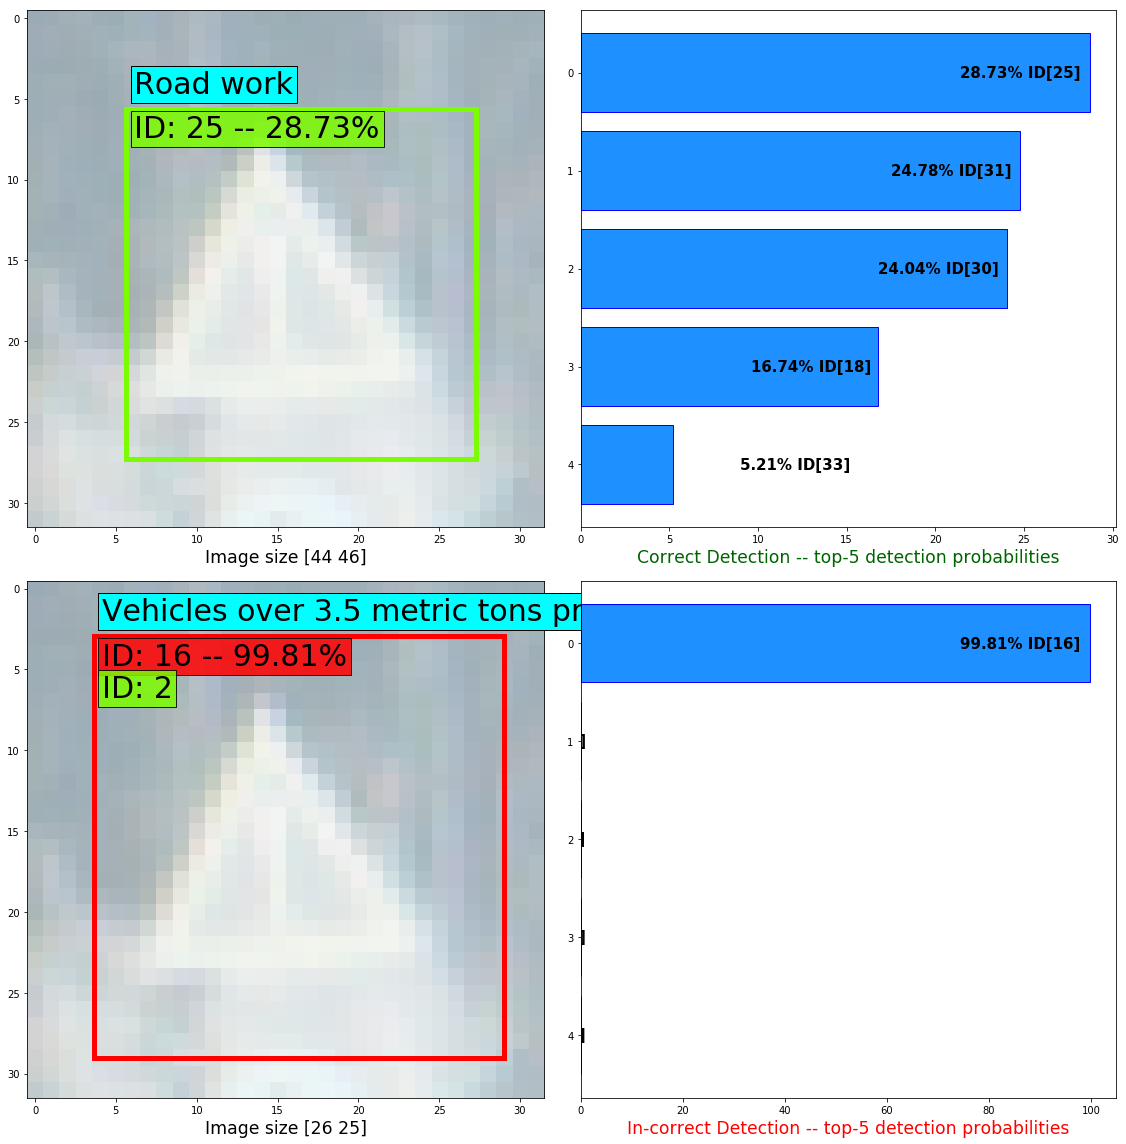

In [19]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

# select one "correct" & "incorrect" detection sample

incorrect_idx = (next(idx for idx in range(len(y_tst)) if ((top5_indices[idx][0]!=y_tst[idx]) and (top5_probs[idx][1]>1e-3)) ))
correct_idx = (next(idx for idx in range(len(y_tst)) if ((top5_indices[idx][0]==y_tst[idx]) and (top5_probs[idx][1]>1e-3)) ))

fig = plt.figure()
plt.subplots(figsize=(16,16))

# plot traffic sign with CORRECT detection probability
ax = plt.subplot(2,2,1)        
plt.imshow(X_[correct_idx])
plt.xlabel('Image size {}'.format(X_train_size[correct_idx]), size='xx-large')
# traffic sign coordinates scaled to 32x32
x1, y1, x2, y2 = X_test_loc[correct_idx]
x1 *= 32/X_test_size[correct_idx][0] 
x2 *= 32/X_test_size[correct_idx][0] 
y1 *= 32/X_test_size[correct_idx][1] 
y2 *= 32/X_test_size[correct_idx][1] 
lbl = top5_indices[correct_idx][0]
prob = top5_probs[correct_idx][0]
if (lbl == y_tst[correct_idx]): # correct detect GREEN
    ax.add_patch(patches.Rectangle((x1,y1), x2-x1, y2-y1, color='lawngreen', linewidth=5, fill=False))
    plt.text(x1+.5,y1+1.75,"ID: {} -- {:.2f}%".format(lbl, prob*100), fontsize=30, bbox=dict(facecolor='lawngreen', alpha=0.85))
else : # incorrect detect RED
    #print(y_tst[select_images[idx]], " : ", top5_indices[select_images[idx]])
    ax.add_patch(patches.Rectangle((x1,y1), x2-x1, y2-y1, color='red', linewidth=5, fill=False))
    plt.text(x1+.5,y1+1.75,"ID: {} -- {:.2f}%".format(lbl, prob*100), fontsize=30, bbox=dict(facecolor='red', alpha=0.85))
    plt.text(x1+.5,y1+3.75,"ID: {}".format(y_tst[correct_idx]), fontsize=30, bbox=dict(facecolor='lawngreen', alpha=0.85))
plt.text(x1+.5,y1-1,"{}".format(signname_hash[str(lbl)]), fontsize=30, bbox=dict(facecolor='cyan', alpha=1.))
ax1 = plt.subplot(2,2,2)
plt.xlabel('Correct Detection -- top-5 detection probabilities', size='xx-large', color='darkgreen')
scores = top5_probs[correct_idx]*100
pos = np.arange(len(scores))
rects = ax1.barh(pos, scores, align='center', height=.8, color='dodgerblue', ec='blue')
# Lastly, write in the ranking inside each bar to aid in interpretation
cnt = 0
for rect in rects:
    width = round(rect.get_width(),2)
    rankStr = str(width)+"% ID["+str(top5_indices[correct_idx][cnt])+"]"
    if (width<10):xloc = width+10 
    else: xloc = 0.98*width
    clr = 'black'
    align = 'right'
    yloc = rect.get_y() + rect.get_height()/2.0
    label = ax1.text(xloc, yloc, rankStr, horizontalalignment=align,
                 verticalalignment='center', color='black', size=15, weight='bold',
                 clip_on=True)
    cnt += 1
ax1.invert_yaxis()

# plot traffic sign with INCORRECT detection probability
ax3 = plt.subplot(2,2,3)        
plt.imshow(X_[correct_idx])
plt.xlabel('Image size {}'.format(X_train_size[incorrect_idx]), size='xx-large')
# traffic sign coordinates scaled to 32x32
x1, y1, x2, y2 = X_test_loc[incorrect_idx]
x1 *= 32/X_test_size[incorrect_idx][0] 
x2 *= 32/X_test_size[incorrect_idx][0] 
y1 *= 32/X_test_size[incorrect_idx][1] 
y2 *= 32/X_test_size[incorrect_idx][1] 
lbl = top5_indices[incorrect_idx][0]
prob = top5_probs[incorrect_idx][0]
if (lbl == y_tst[correct_idx]): # correct detect GREEN
    ax3.add_patch(patches.Rectangle((x1,y1), x2-x1, y2-y1, color='lawngreen', linewidth=5, fill=False))
    plt.text(x1+.5,y1+1.75,"ID: {} -- {:.2f}%".format(lbl, prob*100), fontsize=30, bbox=dict(facecolor='lawngreen', alpha=0.85))
else : # incorrect detect RED
    #print(y_tst[select_images[idx]], " : ", top5_indices[select_images[idx]])
    ax3.add_patch(patches.Rectangle((x1,y1), x2-x1, y2-y1, color='red', linewidth=5, fill=False))
    plt.text(x1+.5,y1+1.75,"ID: {} -- {:.2f}%".format(lbl, prob*100), fontsize=30, bbox=dict(facecolor='red', alpha=0.85))
    plt.text(x1+.5,y1+3.75,"ID: {}".format(y_tst[incorrect_idx]), fontsize=30, bbox=dict(facecolor='lawngreen', alpha=0.85))
plt.text(x1+.5,y1-1,"{}".format(signname_hash[str(lbl)]), fontsize=30, bbox=dict(facecolor='cyan', alpha=1.))
ax2 = plt.subplot(2,2,4)
plt.xlabel('In-correct Detection -- top-5 detection probabilities', size='xx-large', color='red')
scores = top5_probs[incorrect_idx]*100
pos = np.arange(len(scores))
rects = ax2.barh(pos, scores, align='center', height=.8, color='dodgerblue', ec='blue')
# Lastly, write in the ranking inside each bar to aid in interpretation
cnt = 0
for rect in rects:
    width = round(rect.get_width(),2)
    rankStr = str(width)+"% ID["+str(top5_indices[incorrect_idx][cnt])+"]"
    if (width<10):xloc = width+1 
    else: xloc = 0.98*width
    clr = 'black'
    align = 'right'
    yloc = rect.get_y() + rect.get_height()/2.0
    label = ax2.text(xloc, yloc, rankStr, horizontalalignment=align,
                 verticalalignment='center', color='black', size=15, weight='bold',
                 clip_on=True)
    cnt += 1
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('TrafficSigns_LeNet_TestImages_Top5Probs.png', dpi=100)
plt.show()
plt.draw()


## 2.4 German Traffic Sign DB

**Using Test Image Data-set**

[Test Images](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset#Downloads)

Read pre-processed image from pickled cache and apply classifier network. 

In [12]:
#
# Read processed data-set from pickle
#
def print_stats(X, arrayname = ''):
    print(arrayname, ": {StdDev, Mean, Range, Min, Max} =\n\t",X.std(axis=(0,1,2)), X.mean(axis=(0,1,2)), X.ptp(), X.min(axis=(0,1,2)), X.max(axis=(0,1,2)))    
    return

# Load pickled normalized-data
pickle_file = './dataset/GTSRBData_processed.p'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    
    GTSRB_test_images = pickle_data['test_images']
    X_test = pickle_data['test_norm']
    y_test = pickle_data['labels']
    W = pickle_data['width']
    H = pickle_data['height']
    X1 = pickle_data['X1']
    Y1 = pickle_data['Y1']
    X2 = pickle_data['X2']
    Y2 = pickle_data['Y2']
    del pickle_data  # Free up memory

#
# Dataset summary
#
total_samples = len(X_test)
n_classes = len(set(y_test))

print("Unique labels = ",len(set(y_test)))
print("Test set: ")
print("\t Number of samples = ",len(X_test), ":({0:.2f}%)".format(len(X_test)/total_samples*100))
print("\t Image dimension   = ",X_test.shape[1],"x", X_test.shape[2],"x", X_test.shape[3])
print("\t Data types (X, y) = ",X_test.dtype,",", y_test.dtype)
print("\t Data range (X, y) = ",np.ptp(X_test),",", np.ptp(y_test))

print('Data loaded ...')

print('\nData Summary Statistics:')
print_stats(X_test, "test")



Unique labels =  43
Test set: 
	 Number of samples =  12630 :(100.00%)
	 Image dimension   =  32 x 32 x 3
	 Data types (X, y) =  float32 , uint8
	 Data range (X, y) =  1.99219 , 42
Data loaded ...

Data Summary Statistics:
test : {StdDev, Mean, Range, Min, Max} =
	 [ 0.53833121  0.52082473  0.53725523] [-0.36030981 -0.38513294 -0.32748586] 1.99219 [-1.      -0.96875 -1.     ] [ 0.9921875  0.9921875  0.9921875]


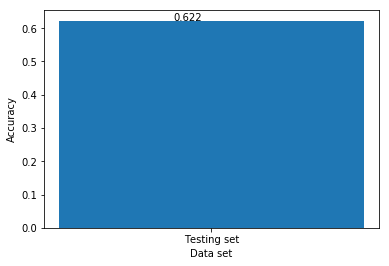

In [13]:
#
# Apply LeNet classifier to GTSRB data-set
#
with tf.Session() as sess:
    saver.restore(sess, './models/lenet_trafficsign.ckpt')
    test_accuracy,_ = evaluate(X_test, y_test)
    # test data detected probabilities
    test_logits = sess.run(logits, feed_dict={x: X_test})
    test_probs = sess.run(tf.nn.softmax(test_logits))
    top5_probs, top5_indices = sess.run(tf.nn.top_k(test_probs, k=5))

accuracy = [test_accuracy]
tick_labels = ["Testing set"]
plt.bar(range(1), accuracy)
plt.xlabel('Data set')
plt.ylabel('Accuracy')
plt.xticks(range(1), tick_labels)
for x_,y_ in zip(range(1), accuracy):
    plt.text(x_ - 0.1, y_, '%.3f'%y_)
plt.show()

**Top-5 Detection Probabilities softmax [logits] for sample test images**

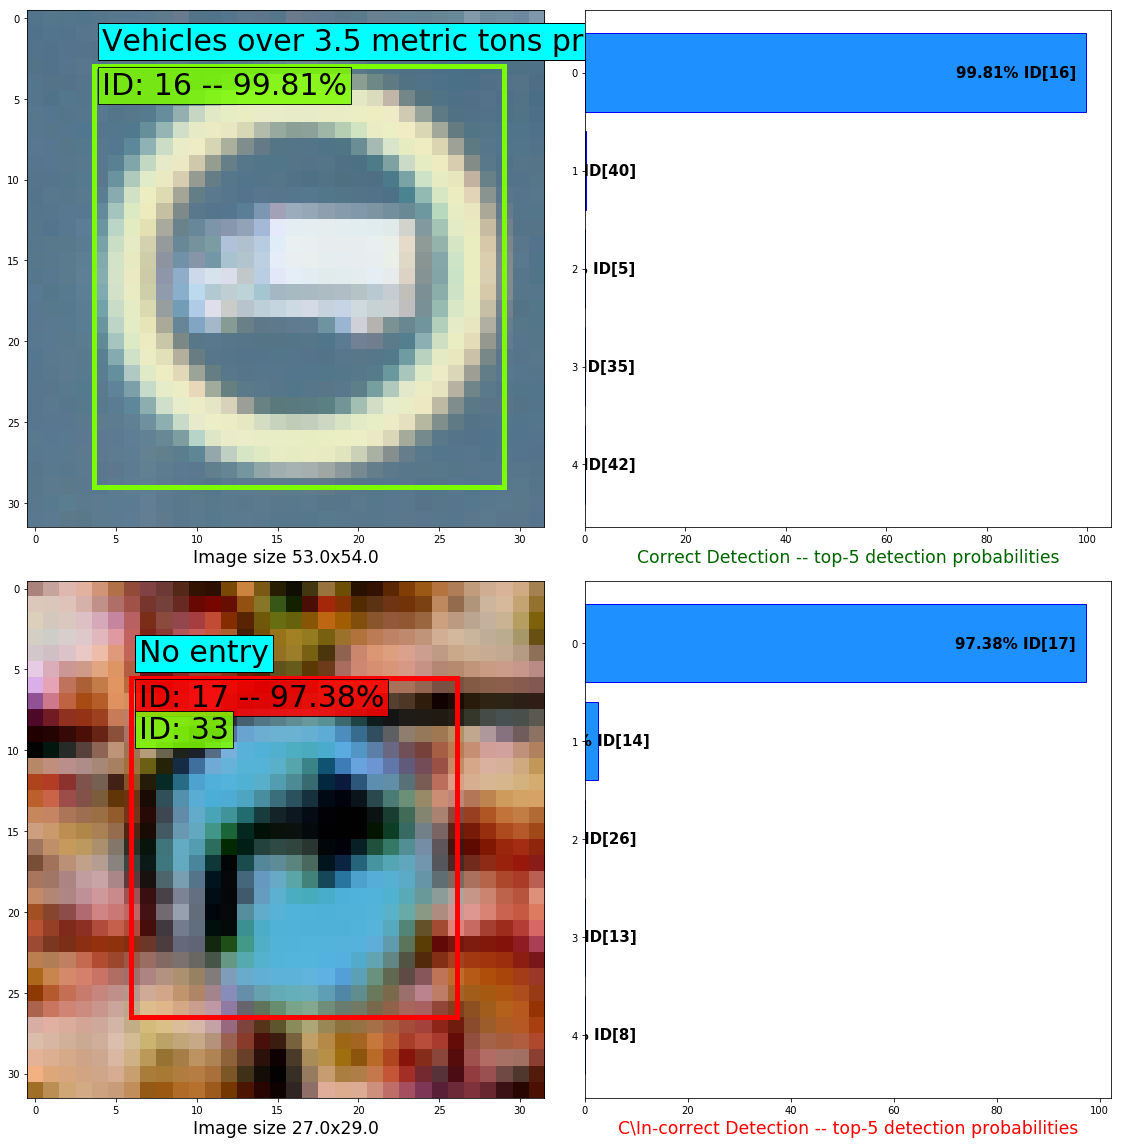

In [20]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
# un-normalize test images for display
X_ = (X_test+1.) * 128.

# select one "correct" & "incorrect" detection sample
incorrect_idx = (next(idx for idx in range(len(y_test)) if ((top5_indices[idx][0]!=y_test[idx]) and (top5_probs[idx][1]>1e-3)) ))
correct_idx = (next(idx for idx in range(len(y_test)) if ((top5_indices[idx][0]==y_test[idx]) and (top5_probs[idx][1]>1e-3)) ))

fig = plt.figure()
plt.subplots(figsize=(16,16))

# plot traffic sign with CORRECT detection probability
ax = plt.subplot(2,2,1)        
plt.imshow(X_[correct_idx])
plt.xlabel('Image size {}x{}'.format(W[correct_idx],H[correct_idx]), size='xx-large')
# traffic sign coordinates scaled to 32x32
x1 = X1[correct_idx] * 32/W[correct_idx] 
x2 = X2[correct_idx] * 32/W[correct_idx]
y1 = Y1[correct_idx] * 32/H[correct_idx] 
y2 = Y2[correct_idx] * 32/H[correct_idx] 
lbl = top5_indices[correct_idx][0]
prob = top5_probs[correct_idx][0]
if (lbl == y_test[correct_idx]): # correct detect GREEN
    ax.add_patch(patches.Rectangle((x1,y1), x2-x1, y2-y1, color='lawngreen', linewidth=5, fill=False))
    plt.text(x1+.5,y1+1.75,"ID: {} -- {:.2f}%".format(lbl, prob*100), fontsize=30, bbox=dict(facecolor='lawngreen', alpha=0.85))
else : # incorrect detect RED
    #print(y_tst[select_images[idx]], " : ", top5_indices[select_images[idx]])
    ax.add_patch(patches.Rectangle((x1,y1), x2-x1, y2-y1, color='red', linewidth=5, fill=False))
    plt.text(x1+.5,y1+1.75,"ID: {} -- {:.2f}%".format(lbl, prob*100), fontsize=30, bbox=dict(facecolor='red', alpha=0.85))
    plt.text(x1+.5,y1+3.75,"ID: {}".format(y_test[correct_idx]), fontsize=30, bbox=dict(facecolor='lawngreen', alpha=0.85))
plt.text(x1+.5,y1-1,"{}".format(signname_hash[str(lbl)]), fontsize=30, bbox=dict(facecolor='cyan', alpha=1.))
ax1 = plt.subplot(2,2,2)
plt.xlabel('Correct Detection -- top-5 detection probabilities', size='xx-large', color='darkgreen')
scores = top5_probs[correct_idx]*100
pos = np.arange(len(scores))
rects = ax1.barh(pos, scores, align='center', height=.8, color='dodgerblue', ec='blue')
# Lastly, write in the ranking inside each bar to aid in interpretation
cnt = 0
for rect in rects:
    width = round(rect.get_width(),2)
    rankStr = str(width)+"% ID["+str(top5_indices[correct_idx][cnt])+"]"
    if (width<10):xloc = width+10 
    else: xloc = 0.98*width
    clr = 'black'
    align = 'right'
    yloc = rect.get_y() + rect.get_height()/2.0
    label = ax1.text(xloc, yloc, rankStr, horizontalalignment=align,
                 verticalalignment='center', color='black', size=15, weight='bold',
                 clip_on=True)
    cnt += 1
ax1.invert_yaxis()

# plot traffic sign with INCORRECT detection probability
ax3 = plt.subplot(2,2,3)        
plt.imshow(X_[incorrect_idx])
plt.xlabel('Image size {}x{}'.format(W[incorrect_idx],H[incorrect_idx]), size='xx-large')
# traffic sign coordinates scaled to 32x32
x1 = X1[incorrect_idx] * 32/W[incorrect_idx] 
x2 = X2[incorrect_idx] * 32/W[incorrect_idx]
y1 = Y1[incorrect_idx] * 32/H[incorrect_idx] 
y2 = Y2[incorrect_idx] * 32/H[incorrect_idx] 
lbl = top5_indices[incorrect_idx][0]
prob = top5_probs[incorrect_idx][0]
if (lbl == y_test[incorrect_idx]): # correct detect GREEN
    ax3.add_patch(patches.Rectangle((x1,y1), x2-x1, y2-y1, color='lawngreen', linewidth=5, fill=False))
    plt.text(x1+.5,y1+1.75,"ID: {} -- {:.2f}%".format(lbl, prob*100), fontsize=30, bbox=dict(facecolor='lawngreen', alpha=0.85))
else : # incorrect detect RED
    #print(y_tst[select_images[idx]], " : ", top5_indices[select_images[idx]])
    ax3.add_patch(patches.Rectangle((x1,y1), x2-x1, y2-y1, color='red', linewidth=5, fill=False))
    plt.text(x1+.5,y1+1.75,"ID: {} -- {:.2f}%".format(lbl, prob*100), fontsize=30, bbox=dict(facecolor='red', alpha=0.85))
    plt.text(x1+.5,y1+3.75,"ID: {}".format(y_test[incorrect_idx]), fontsize=30, bbox=dict(facecolor='lawngreen', alpha=0.85))
plt.text(x1+.5,y1-1,"{}".format(signname_hash[str(lbl)]), fontsize=30, bbox=dict(facecolor='cyan', alpha=1.))
ax2 = plt.subplot(2,2,4)
plt.xlabel('In-correct Detection -- top-5 detection probabilities', size='xx-large', color='red')
scores = top5_probs[incorrect_idx]*100
pos = np.arange(len(scores))
rects = ax2.barh(pos, scores, align='center', height=.8, color='dodgerblue', ec='blue')
# Lastly, write in the ranking inside each bar to aid in interpretation
cnt = 0
for rect in rects:
    width = round(rect.get_width(),2)
    rankStr = str(width)+"% ID["+str(top5_indices[incorrect_idx][cnt])+"]"
    if (width<10):xloc = width+10 
    else: xloc = 0.98*width
    clr = 'black'
    align = 'right'
    yloc = rect.get_y() + rect.get_height()/2.0
    label = ax2.text(xloc, yloc, rankStr, horizontalalignment=align,
                 verticalalignment='center', color='black', size=15, weight='bold',
                 clip_on=True)
    cnt += 1
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('TrafficSigns_LeNet_GTSRBTestImages_Top5Probs.png', dpi=100)
plt.show()
plt.draw()


---

## 2.5 Visualizing the Neural Network State (`weights`) with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [23]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
            
            
with tf.Session() as sess:
    saver.restore(sess, './models/lenet_trafficsign.ckpt')
            
    # select LeNet 1st layer weights as applied to GTSRB image #5
    #print(weights['wc1'])
    outputFeatureMap(X_[5], weights['wc1'])

NameError: name 'weights' is not defined